# dog_vs_cat
1. 创建数据集
2. 数据预处理
3. 定义模型

## 1. 创建数据集

In [1]:
import os
import shutil
import torch
import h5py
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision import models
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder

use_cuda = torch.cuda.is_available()                    # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')    # 优先使用gpu

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 10

In [3]:
root_path = os.path.join('..', 'data', 'dog_vs_cat')     # 数据集的根目录     
source_path = os.path.join(root_path, 'kaggle_train')    # 原图像的目录
print('Data path:', root_path)

Data path: ..\data\dog_vs_cat


### 1.1 创建dog和cat的目录

In [4]:
def create_dir(class_name, phase):
    """
    class_name：类别名称，字符串
    phase：train或val
    """
    img_folder = os.path.join(root_path, phase, class_name)
    if not os.path.exists(img_folder):     
        os.mkdir(img_folder)           # 只能创建一个文件夹，无法创建嵌套的文件夹
        print(img_folder)
    
dir_list = [(i,j) for i in ['dog', 'cat'] for j in ['train', 'val']]  # 分为训练集和验证集
print(dir_list)
operation = list(map(lambda x: create_dir(*x), dir_list))             # 创建4个对应的目录

[('dog', 'train'), ('dog', 'val'), ('cat', 'train'), ('cat', 'val')]


### 1.2 将图像存放到对应路径

In [5]:
data_list = os.listdir(source_path)   # 列出原数据集中文件名，列表类型
print(data_list[:7])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg']


In [6]:
dog_list = list(filter(lambda x:x[:3]=='dog', data_list))     # 筛选出dog类型的文件 列表数据
print(dog_list[:7])
cat_list = list(filter(lambda x:x[:3]=='cat', data_list))     # 筛选cat类型文件 
print(cat_list[:7])

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg']
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg']


In [7]:
# 运行该程序会显示进度条
def copy_data(root_path, file_list, target_class):
    """
    root_path：文件的根目录
    file_list：需要复制的文件的list
    target_class：需要复制的文件所属类别
    """
    for i in tqdm_notebook(range(len(file_list))):                  # tqdm为了显示进度条
        source_path = os.path.join(root_path, 'kaggle_train', file_list[i])
#         print(source_path)
        phase = 'train' if i < len(dog_list)*0.9 else 'val'         # 选取90%数据为训练，10%验证  
        target_path = os.path.join(root_path, phase, target_class, file_list[i])  # 创建目标目录
#         print(target_path)
        if not os.path.exists(target_path):         # 如果目标文件不存在
            shutil.copy(source_path, target_path)   # 复制文件到指定目录
copy_data(root_path, cat_list, 'cat')  
copy_data(root_path, dog_list, 'dog')

HBox(children=(IntProgress(value=0, max=12500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12500), HTML(value='')))

### 1.3 显示样本

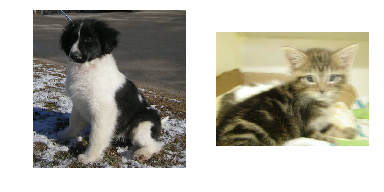

In [8]:
%matplotlib inline
dog_sample = np.random.choice(dog_list, size=1)    # 从列表汇总随机选取一个样本
cat_sample = np.random.choice(cat_list, size=1)
dog_img = plt.imread(os.path.join(root_path, 'kaggle_train', dog_sample[0]))# (191, 119, 3)
# print(dog_img.shape)
cat_img = plt.imread(os.path.join(root_path, 'kaggle_train', cat_sample[0]))
fig = plt.figure(figsize=(6,3))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(dog_img)
fig.add_subplot(122)
plt.axis('off')
plt.imshow(cat_img)

---
## 2. 数据预处理

### 2.1 数据预处理

In [63]:
# 定义数据预处理方法
img_transform = transforms.Compose([
    transforms.Resize(250),                             # 缩放到250*250
    transforms.CenterCrop(224),                         # 裁剪中心224*224尺寸的图像
    transforms.ToTensor(),                              # 转换为[0,1]的向量
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 转换为[-1,1]，数据零均值处理
])
def datafolder(phase):        
    """
    func：读取数据并返回ImageFolder类
    phase：train或者val
    """
    data = ImageFolder(os.path.join(root_path, phase), transform=img_transform)
#     print(data)
    return data
da = datafolder('val')
da.class_to_idx                       # ImageFolder函数为不同名称文件夹自动分配了类别号

{'cat': 0, 'dog': 1}

### 2.2 生成批次数据

In [10]:
def dataloader(data_folder, batch_size, phase='train'):
    """
    func：读取数据并返回DataLoader类
    data_folder：数据的ImageFolder
    batch_size：批次的大小
    phase：train或者val
    """    
    loader = DataLoader(data_folder, batch_size=batch_size, shuffle=False, num_workers=4)
    return loader  

In [11]:
train_loader = dataloader(datafolder('train'), batch_size, 'train')   # 创建数据迭代器
val_loader = dataloader(datafolder('val'), batch_size, 'val')

In [12]:
print('train numbers:', len(train_loader.dataset))
print('val numbers:', len(val_loader.dataset))

train numbers: 22500
val numbers: 2500


In [55]:
val_data = iter(val_loader)
x, y = next(val_data)
print(x.shape, y.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


---

## 3. 定义模型

### 3.1 定义提取特征的模型

In [14]:
# 2.1定义模型来提取特征，为了提取特征向量
class feature_net(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name                                        # 添加名字属性，便于识别
        assert model_name in ['inceptionv3', 'resnet18', 'squeeze'], 'Wrong model name!'
        if model_name == 'inceptionv3':
            inception = models.inception_v3(pretrained=True)                # 使用预训练模型
            self.features = nn.Sequential(*list(inception.children())[:-1]) # 除去最后一层
            self.features._modules.pop('13')                                # 移除13层辅助分类层
            # 网络最后输出(N,2048,26,26) => [N, 2048, 1, 1] 
            self.features.add_module('global average', nn.AvgPool2d(26))    # get (N, 2048, 1,1)
        elif model_name == 'resnet18':
            resnet = models.resnet18(pretrained=True)
            self.features = nn.Sequential(*list(resnet.children())[:-1])    # (N, 512, 1, 1)
        elif model_name == 'squeeze':
            squeezenet = models.squeezenet1_1(pretrained=True)
            self.features = nn.Sequential(*list(squeezenet.children())[:-1]) # (N, 512, 13, 13)
            self.features.add_module('global average', nn.AvgPool2d(13))     # (N, 512, 1, 1)
    def forward(self, x):
        features = self.features(x)  # 提取特征
        features_flatten = features.view(x.size(0), -1)
        return features_flatten

In [15]:
feature_model = feature_net('resnet18')   # 模型测试
test_in = torch.randn(1,3,224,224)
out = feature_model(test_in)
print(out.shape)

torch.Size([1, 512])


### 3.2 定义分类模型

In [30]:
class classifier(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 512),           # (N,100)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_classes)            # (N,out_classes)
        )
    def forward(self, x):
        out = self.fc(x)
        return out

In [31]:
classifier_model = classifier(200, 2)   # 模型测试
test_in = torch.randn(10, 200)
out = classifier_model(test_in)
print(out.shape)

torch.Size([10, 2])


---
## 4.提取特征并存为h5文件

In [18]:
# 定义提取特征函数
def CreateFeature(model, dataloader, phase, save_path='./feature_h5'):
    """
    model：用于提取特征的模型
    dataloader：train、val时使用的数据迭代器
    phase：train或val
    save_path：特征h5文件保存的路径
    """
    model.to(device)                               # 优先使用GPU
    feature_map = torch.FloatTensor().to(device)
    label_map = torch.LongTensor().to(device)
    idx = 0
    for data in tqdm_notebook(dataloader):         # 显示进度条
        img, label = data
#         print(img.shape)
        img, label = map(lambda x:x.to(device), [img, label])   # 选择设备，优先使用GPU
        out = model(img)                           # 提取特征
        feature_map = torch.cat([feature_map, out.data], 0)     # 在批次方向拼接 (N,-1)
        label_map = torch.cat([label_map, label], 0)
#         print(feature_map.shape)
#         print(label_map.shape)
#         print('--------------')
#         idx += 1
#         if idx == 2:
#             break
#     feature_map = feature_map.cpu().numpy()  # 
    label_map = label_map.cpu().numpy()
    file_name = '{}_{}_feature.hd5f'.format(model.model_name, phase)      # h5文件名称
    h5_path = os.path.join(save_path, file_name)
#     print(h5_path)
    with h5py.File(h5_path, 'w') as h5_file:
        h5_file.create_dataset('data', data=feature_map)
        h5_file.create_dataset('label', data=label_map)
    print('Finished!')

In [19]:
# 创建模型resnet并提取特征
resnet = feature_net('resnet18')
if not os.path.exists(os.path.join('./feature_h5/', 'resnet18_train_feature.hd5f')): # 如果存在就不提特征
    CreateFeature(resnet, train_loader, 'train')
if not os.path.exists(os.path.join('./feature_h5/', 'resnet18_val_feature.hd5f')): # 如果存在就不提特征
    CreateFeature(resnet, val_loader, 'val')

In [20]:
# 创建模型squeezenet并提取特征
squeezenet = feature_net('squeeze')
if not os.path.exists(os.path.join('./feature_h5/', 'squeeze_train_feature.hd5f')): # 如果存在就不提特征
    CreateFeature(squeezenet, train_loader, 'train')
if not os.path.exists(os.path.join('./feature_h5/', 'squeeze_val_feature.hd5f')): # 如果存在就不提特征
    CreateFeature(squeezenet, val_loader, 'val')    

D:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
D:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


<center>生成的特征h5文件</center>
<img src='image/h5_file.jpg' height='45%', width='45%' ></img>

---
## 5. h5特征训练分类器

### 5.1 读取h5数据并按照特征维度拼接

In [21]:
# 定义h5数据读取类，将不同模型的h5特征进行拼接
class h5Dataset(Dataset):
    def __init__(self, file_list):
        """
        file_list：需要拼接的h5文件路径列表
        """
        h5_data = torch.FloatTensor()
        for file in file_list:
            with h5py.File(file, 'r') as temp_file:
                # 读取图像和标签
                temp_data = temp_file['data'].value
                # 转换为torch数据
                temp_data = torch.from_numpy(temp_data)
                if h5_data.shape == torch.Size([0]):                 # 首次读取数据
                    self.label = torch.from_numpy(temp_file['label'].value)  # 保存标签
                    
                h5_data = torch.cat([h5_data, temp_data], 1)        # 在列上拼接                 
        self.data  = h5_data                                        # 保存特征数据
#         print(self.data.shape, self.label.shape)
        
    def __len__(self):                                # 返回一个python常数
        return self.label.shape[0]                    # torch.Size([22500])，使用[0]提取数
    
    def __getitem__(self, index):                     # 按索引读取数据
        assert index < len(self), 'index range error'
        data = self.data[index]
        label = self.label[index]
        return (data, label)

In [22]:
# 生成训练集的dataset  x:[22500,1024] y:[22500]
train_h5_list = [os.path.join('./feature_h5', 'resnet18_train_feature.hd5f'),
                 os.path.join('./feature_h5', 'squeeze_train_feature.hd5f')]
train_h5 = h5Dataset(train_h5_list)
print('Train numbers:', train_h5.__len__())
sample_data, sample_label = train_h5.__getitem__(0)
print('Sample:',sample_data, sample_label)
print(sample_data.shape, sample_label.shape)

Train numbers: 22500
Sample: tensor([0.6055, 0.1336, 0.0773,  ..., 0.0970, 2.7742, 0.3208]) tensor(0)
torch.Size([1024]) torch.Size([])


In [23]:
# 生成验证集的dataset   x:[2500,1024] y:[2500]
val_h5_list = [os.path.join('./feature_h5', 'resnet18_val_feature.hd5f'),
                 os.path.join('./feature_h5', 'squeeze_val_feature.hd5f')]
val_h5 = h5Dataset(val_h5_list)
print('Val numbers:', val_h5.__len__())

Val numbers: 2500


### 5.2 生成批次训练数据

In [44]:
train_batch = 32  # 与开头的批次不同，这里的用于训练分类器
train_h5_loader = DataLoader(train_h5, batch_size=train_batch, shuffle=True)   # 使用num_workers会报错
val_h5_loader = DataLoader(val_h5, batch_size=train_batch, shuffle=False)

In [45]:
val_h5_data = iter(val_h5_loader)
x, y = next(val_h5_data)
print(x.shape, y.shape)

torch.Size([32, 1024]) torch.Size([32])


### 5.3. 训练分类器

In [132]:
import time
classifier_model = classifier(1024, 2)   # 训练分类器,1024是特征的维度
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-2)

In [147]:
epoches = 5
trainY = []
valY = []
total_train = len(train_h5_loader.dataset)         # 总训练样本数
total_val = len(val_h5_loader.dataset)             # 总验证样本数
# print(total_number)
for epoch in range(epoches):
    print('{}Epoch:{}{}'.format('-'*20, epoch+1, '-'*20))
    start = time.time()                             # 开始时间
    train_loss = 0
    train_acc = 0
    for i,data in enumerate(train_h5_loader, 1):    # 后面参数1使i从1开始
        feature, label = data                       # 读取数据
        feature, label = map(lambda x:x.to(device), [feature, label]) 
#         print(feature.shape, label.shape)
        classifier_model.to(device)
    
        out = classifier_model(feature)             # 前向传播 (N,1024)
#         print(out.shape)
        loss = criterion(out,label)
        print_loss = loss.item()
#         print(print_loss)
        optimizer.zero_grad()                       # 梯度归零
        loss.backward()                             # 反向传播
        optimizer.step()                            # 更新参数
        
        train_loss += print_loss*label.shape[0]     # 累加一个批次的损失，损失函数默认取平均
        _, pred = torch.max(out, 1)                 # 取最大的值为输出
        num_correct = torch.sum(pred==label)        # 统计正确的数目
        train_acc += num_correct.item()
        if i %50 == 0:
            current_loss = train_loss/(i*train_batch)
            current_acc  = train_acc/(i*train_batch)
            trainY.append(current_loss)
            print('Loss: {:.4f}, Acc: {:.4f}'.format(current_loss, current_acc))
    train_loss /= total_train
    train_acc /= total_train
    period_time = time.time() - start              # 统计一个epoch的耗时
    print('Loss: {:.4f}, Acc: {:.4f}, Time: {:.0f}s'.format(
        train_loss, train_acc, period_time))
    
    # 进行模型验证
    print('Validation:', end=' ')
    classifier_model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in val_h5_loader:
        feature, label = data
        feature, label = map(lambda x:x.to(device), [feature, label])
        out = classifier_model(feature)
        loss = criterion(out, label)
        _, pred = torch.max(out, 1)
        correct_num = torch.sum(pred==label)
        eval_acc += correct_num.item()
        eval_loss += loss.item() * label.shape[0]
    current_val_loss = eval_loss/total_val
    valY.append(current_val_loss)
    print('Loss: {:.4f}, Acc: {:.4f}'.format(current_val_loss, eval_acc/total_val))
print('Finish Training!')
model_path = os.path.join('.', 'model')
if not os.path.exists(model_path):
    os.mkdir(model_path)
save_path = os.path.join(model_path, 'fc2_model.pth')
torch.save(classifier_model.state_dict(), save_path)

--------------------Epoch:1--------------------
Loss: 0.0068, Acc: 0.9981
Loss: 0.0104, Acc: 0.9969
Loss: 0.0080, Acc: 0.9977
Loss: 0.0093, Acc: 0.9973
Loss: 0.0113, Acc: 0.9968
Loss: 0.0130, Acc: 0.9961
Loss: 0.0118, Acc: 0.9963
Loss: 0.0125, Acc: 0.9962
Loss: 0.0117, Acc: 0.9963
Loss: 0.0112, Acc: 0.9964
Loss: 0.0107, Acc: 0.9966
Loss: 0.0113, Acc: 0.9964
Loss: 0.0108, Acc: 0.9965
Loss: 0.0106, Acc: 0.9966
Loss: 0.0107, Acc: 0.9965, Time: 3s
Validation: Loss: 0.0311, Acc: 0.9928
--------------------Epoch:2--------------------
Loss: 0.0344, Acc: 0.9912
Loss: 0.0264, Acc: 0.9928
Loss: 0.0266, Acc: 0.9929
Loss: 0.0239, Acc: 0.9931
Loss: 0.0209, Acc: 0.9938
Loss: 0.0199, Acc: 0.9938
Loss: 0.0185, Acc: 0.9939
Loss: 0.0168, Acc: 0.9945
Loss: 0.0158, Acc: 0.9948
Loss: 0.0153, Acc: 0.9949
Loss: 0.0150, Acc: 0.9951
Loss: 0.0150, Acc: 0.9952
Loss: 0.0149, Acc: 0.9951
Loss: 0.0144, Acc: 0.9954
Loss: 0.0143, Acc: 0.9954, Time: 2s
Validation: Loss: 0.0285, Acc: 0.9908
--------------------Epoch:3-

704

1. `torch.FloatTensor()`零维度的向量可以直接与其他维度的向量进行torch.cat拼接
2. CrossEntropyLoss对预测输出的大小没有要求，但标签必须是在[0,class-1]内的数字，并且是LongTensor；
BCELoss损失函数，预测输出必须在(0,1)内，并且目标是FloatTensor，且维度与预测输出维度一致

In [124]:
loss = nn.BCELoss()
# loss = nn.CrossEntropyLoss()
out = torch.ones([3,2])
print(out.shape)
target = torch.FloatTensor(3,2)
print(target.shape)
loss(out,target)

torch.Size([3, 2])
torch.Size([3, 2])


tensor(27.6310)

In [76]:
?torch.randint